In [76]:
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
train_dir='E:/edi/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir='E:/edi/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir='E:/edi/test/test'

In [78]:
Size=224
X_test=[]
y_test=[]

In [79]:
import tensorflow as tf
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(train_dir,batch_size=64,target_size=(Size,Size),subset="training",shuffle=True)

Found 63282 images belonging to 38 classes.


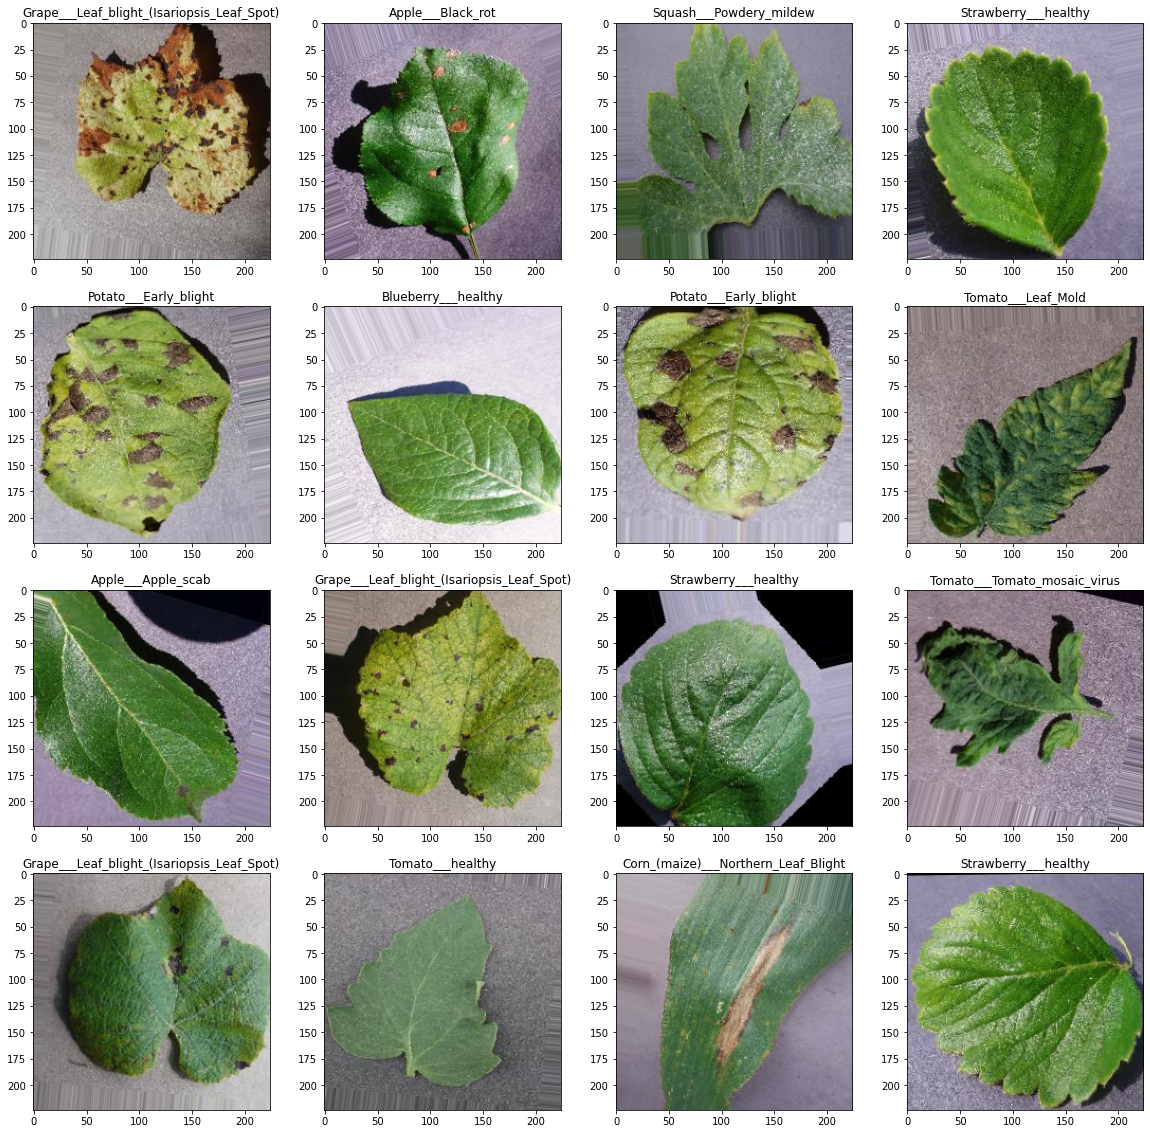

In [80]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [81]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,
    rescale=1/255.0,
    validation_split=0.1
).flow_from_directory(train_dir,batch_size=64,target_size=(Size,Size),subset='validation',shuffle=False)

Found 7013 images belonging to 38 classes.


In [82]:
X_test=[]
for folder in os.listdir(test_dir):
    files=gb.glob(test_dir+'/*.JPG')
    for file in files :
        img=cv.imread(file)
        X_test.append(cv.resize(img,(Size,Size)))

In [83]:
X_test=np.array(X_test)
print(X_test.shape)

(1089, 224, 224, 3)


In [84]:
X_test=X_test/255.0

In [85]:
import keras
from keras.layers import Flatten , Dense , Dropout , BatchNormalization , MaxPooling2D ,Conv2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

#from keras.applications import vgg19

In [86]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [87]:
model=Sequential([
                Conv2D(32,3,activation='relu',kernel_initializer='he_normal',input_shape=(Size,Size,3)),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(64,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(256,3,activation='relu',kernel_initializer='he_normal'),
                BatchNormalization(),
                MaxPooling2D(3),
#vgg19(include_top=False,input_shape=(Size,Size,3)),
                Flatten(),
                Dense(512,activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                BatchNormalization(),
                Dense(256,activation='relu'),
                Dropout(0.2),
                BatchNormalization(),
                Dense(38,activation='softmax')
])

In [88]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [89]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=10,batch_size=64,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)

Epoch 1/10
61/61 [==============================] - ETA: 0s - loss: 2.8398 - accuracy: 0.2467
Epoch 1: val_loss improved from inf to 4.77019, saving model to model.hdf5
61/61 [==============================] - 171s 3s/step - loss: 2.8398 - accuracy: 0.2467 - val_loss: 4.7702 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
61/61 [==============================] - ETA: 0s - loss: 2.0246 - accuracy: 0.4165
Epoch 2: val_loss did not improve from 4.77019
61/61 [==============================] - 153s 2s/step - loss: 2.0246 - accuracy: 0.4165 - val_loss: 5.7703 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10
61/61 [==============================] - ETA: 0s - loss: 1.6993 - accuracy: 0.5031
Epoch 3: val_loss did not improve from 4.77019
61/61 [==============================] - 148s 2s/step - loss: 1.6993 - accuracy: 0.5031 - val_loss: 5.2287 - val_accuracy: 0.0755 - lr: 0.0010
Epoch 4/10
61/61 [==============================] - ETA: 0s - loss: 1.4421 - accuracy: 0.5774
Epoch 4: val_loss 

In [90]:
ModelLoss, ModelAccuracy = model.evaluate(valid_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

110/110 [==============================] - 48s 433ms/step - loss: 1.8269 - accuracy: 0.5808
Test Loss is 1.8268988132476807
Test Accuracy is 0.5807785391807556


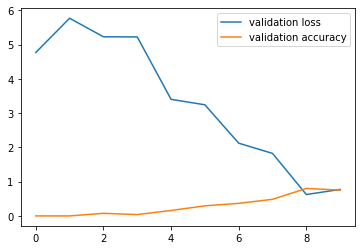

In [91]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()

In [92]:
predictions=model.predict(valid_generator)

In [93]:
from sklearn.metrics import classification_report
print(classification_report(valid_generator.classes, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       201
           1       0.17      0.93      0.28       198
           2       0.81      0.83      0.82       176
           3       0.42      0.79      0.55       200
           4       0.82      0.33      0.47       181
           5       0.96      0.82      0.88       168
           6       0.75      0.84      0.79       182
           7       0.85      0.49      0.63       164
           8       0.61      0.99      0.76       190
           9       0.85      0.89      0.87       190
          10       0.87      0.99      0.93       185
          11       0.67      0.45      0.54       188
          12       0.72      0.82      0.77       192
          13       0.88      0.78      0.83       172
          14       0.36      0.92      0.52       169
          15       0.68      1.00      0.81       201
          16       0.59      0.67      0.63       183
          17       0.64    

<AxesSubplot:>

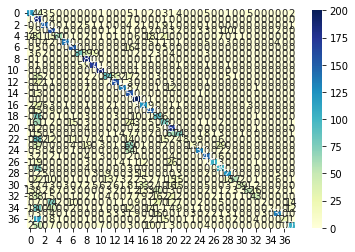

In [94]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_generator.classes, predictions.argmax(axis=1))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

<AxesSubplot:>

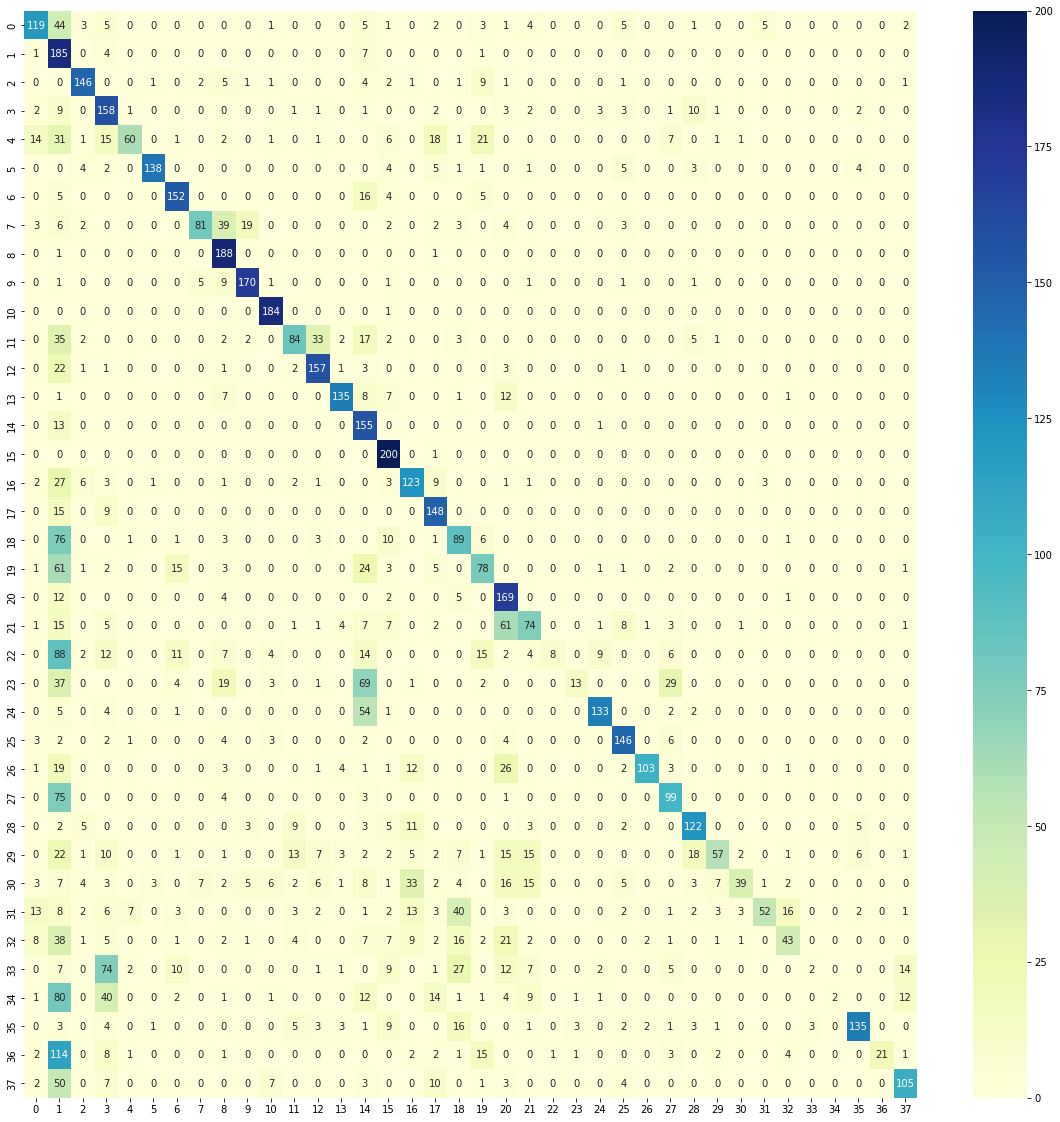

In [95]:
plt.figure(figsize=(20,20))
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [96]:
y_pred=model.predict(X_test)

In [97]:
y_pred[0]

array([1.2508897e-05, 1.2261668e-01, 2.9822531e-05, 5.1123810e-05,
       5.9982294e-06, 3.3301387e-08, 2.9031892e-04, 3.0016671e-09,
       3.1542613e-03, 4.0732430e-06, 2.1896318e-03, 4.7171521e-03,
       5.0309021e-02, 1.5969391e-04, 5.8798697e-03, 8.5150430e-05,
       8.9503999e-05, 1.4681874e-05, 2.0802226e-04, 8.0333847e-01,
       2.5463610e-06, 2.8513008e-07, 4.5502866e-03, 3.1568878e-05,
       4.1569135e-04, 2.3172724e-06, 1.2021512e-05, 2.3037035e-04,
       8.5654456e-06, 2.7909515e-05, 3.9134353e-08, 5.1696945e-09,
       1.3914252e-04, 1.0543878e-09, 1.3563026e-06, 8.1504058e-06,
       1.4111511e-03, 2.6300465e-06], dtype=float32)

In [98]:
predictions=y_pred.argmax(axis=1)

In [99]:
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [100]:
predictions

array([19, 25, 19, ..., 12, 12, 12], dtype=int64)

In [101]:
predictions[0]


19

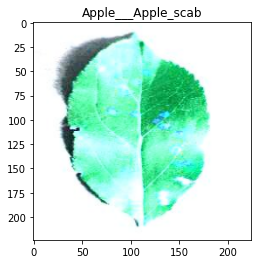

In [102]:
plt.imshow(X_test[0])
# plt.title(classes[predictions[0]])
plt.title(classes[valid_generator.index_array[0]])
plt.show()